# Measurement campaign

This example represent a sensor measurement campaign.

It shows that :
- data can simply be represented in multidimensional format and used in Xarray
- the multidimensional JSON format is the most compact of the usual formats (tabular JSON, csv and even parquet),

## description

Sensors are installed in five french cities (lille, toulouse, marseille, strasbourg, brest) and measure air quality during ten days.
The measurement is the hourly mean of pollutants concentration (PM10, PM2.5, NO2, O3, CO).

The result of the acquisition is a table where fields are:

- camp : description of the campaign
- date : date of the measurement
- hour : hour of the measurement
- city : location of the sensor
- coord : coordinate of the sensor
- prop : measured property
- unit : unit of the measurement
- value : value of the measurement

## data acquisition

This section is a simulation of the data acquisition by sensors.
The result of the campaign is a pandas DataFrame.

In [113]:
columns = ['camp', 'date', 'hour', 'city', 'coord', 'prop', 'unit', 'value']

camp = 'air quality sensor measurement'
dates = ['2024/05/24', '2024/05/25', '2024/05/26', '2024/05/27', '2024/05/28', 
         '2024/05/29', '2024/05/30', '2024/05/31', '2024/06/01', '2024/06/02']
cities = ['lille', 'toulouse', 'marseille', 'strasbourg', 'brest']
coordinates = ['[3.06, 50.63]', '[1.44, 43.6]', '[5.37, 43.3]', '[7.75, 48.57]', '[4.49, 48.39]']
properties = ['PM10', 'PM2.5', 'NO2', 'O3', 'CO']
units = ['µg/m3', 'µg/m3', 'µg/m3', 'µg/m3', 'mg/m3']
hours = list(range(24))

In [114]:
import os
from random import random

data = []
for city, coord in zip(cities, coordinates):
    for date in dates:
        for hour in hours:
            for prop, unit in zip(properties, units):
                data.append((camp, date, hour, city, coord, prop, unit, round(random()*10, 2)))

In [115]:
import pandas as pd

meas_df = pd.DataFrame(data, columns=columns).sample(frac=1).reset_index(drop=True)
meas_df

,camp,date,hour,city,coord,prop,unit,value
0,air quality sensor measurement,2024/05/26,7,marseille,"[5.37, 43.3]",PM2.5,µg/m3,2.74
1,air quality sensor measurement,2024/06/02,4,brest,"[4.49, 48.39]",PM2.5,µg/m3,5.95
2,air quality sensor measurement,2024/05/30,20,strasbourg,"[7.75, 48.57]",PM10,µg/m3,7.93
3,air quality sensor measurement,2024/05/28,16,brest,"[4.49, 48.39]",PM2.5,µg/m3,0.53
4,air quality sensor measurement,2024/06/02,11,marseille,"[5.37, 43.3]",O3,µg/m3,9.56
...,...,...,...,...,...,...,...,...
5995,air quality sensor measurement,2024/05/25,16,toulouse,"[1.44, 43.6]",PM10,µg/m3,1.06
5996,air quality sensor measurement,2024/05/27,15,strasbourg,"[7.75, 48.57]",PM2.5,µg/m3,4.67
5997,air quality sensor measurement,2024/05/27,1,marseille,"[5.37, 43.3]",CO,mg/m3,0.71
5998,air quality sensor measurement,2024/06/01,13,toulouse,"[1.44, 43.6]",NO2,µg/m3,7.44


## Multidimensional representation

In [116]:
import xarray as xr
import ntv_pandas

meas_xr = meas_df.npd.to_xarray()
meas_xr

<xarray.Dataset> Size: 49kB
Dimensions:  (date: 10, hour: 24, city: 5, prop: 5)
Coordinates:
  * city     (city) <U10 200B 'brest' 'lille' ... 'strasbourg' 'toulouse'
  * date     (date) <U10 400B '2024/05/24' '2024/05/25' ... '2024/06/02'
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * prop     (prop) <U5 100B 'CO' 'NO2' 'O3' 'PM10' 'PM2.5'
    coord    (city) <U13 260B '[4.49, 48.39]' '[3.06, 50.63]' ... '[1.44, 43.6]'
    unit     (prop) <U5 100B 'mg/m3' 'µg/m3' 'µg/m3' 'µg/m3' 'µg/m3'
    camp     <U30 120B 'air quality sensor measurement'
Data variables:
    value    (date, hour, city, prop) float64 48kB 2.13 7.36 8.13 ... 1.22 3.11

In [117]:
meas_xr.sel(city='lille', prop='NO2', hour=0).values

<bound method Mapping.values of <xarray.Dataset> Size: 740B
Dimensions:  (date: 10)
Coordinates:
    city     <U10 40B 'lille'
  * date     (date) <U10 400B '2024/05/24' '2024/05/25' ... '2024/06/02'
    hour     int64 8B 0
    prop     <U5 20B 'NO2'
    coord    <U13 52B '[3.06, 50.63]'
    unit     <U5 20B 'µg/m3'
    camp     <U30 120B 'air quality sensor measurement'
Data variables:
    value    (date) float64 80B 6.63 8.62 3.3 1.32 6.19 2.79 7.65 5.8 6.95 8.23>

## data size

In [118]:
size = {'pd.to_json(values)': len(meas_df.to_json(orient='values')),
          'pd.to_csv': len(meas_df.to_csv())
         }

In [119]:
meas_df.to_csv('meas.csv')
# meas.parquet: https://dataconverter.io/convert/csv-to-parquet/download (UNCOMPRESSED, HALF_UP)
size |= {'pd.to_parquet': os.path.getsize('meas_10.parquet')}

In [120]:
import ntv_numpy

notype = [True]*len(meas_df.columns)
meas_js = meas_xr.nxr.to_json(notype=notype, header=False, encoded=True)
size |= {'nxr.to_json': len(meas_js)}
size

{'pd.to_json(values)': 616091,
 'pd.to_csv': 537024,
 'pd.to_parquet': 79604,
 'nxr.to_json': 36075}

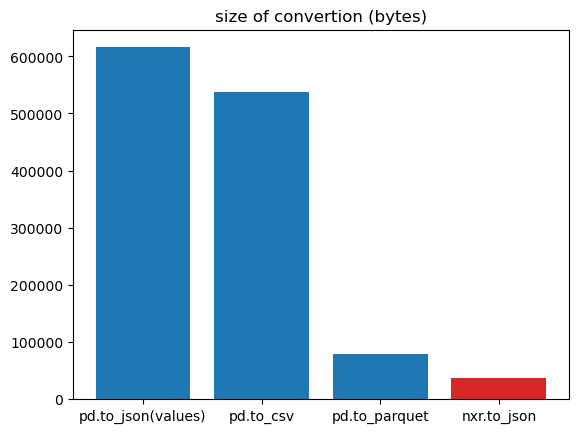

In [108]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
bar_colors = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:red']
ax.bar(result.keys(), result.values(), color=bar_colors)
ax.set_title('size of convertion (bytes)')
plt.show()

In [67]:
columns = ['date', 'hour', 'city', 'coord', 'prop', 'unit', 'value']

dates = ['2024/05/24']
cities = ['lille', 'toulouse', 'marseille', 'strasbourg', 'brest']
coordinates = [[3.06, 50.63], [1.44, 43.6], [5.37, 43.3], [7.75, 48.57], [4.49, 48.39]]
properties = ['PM10', 'PM2.5', 'NO2', 'O3', 'CO']
units = ['µg/m3', 'µg/m3', 'µg/m3', 'µg/m3', 'mg/m3']
hours = list(range(24))

In [68]:
from random import random

data = []
for city, coord in zip(cities, coordinates):
    for date in dates:
        for hour in hours:
            for prop, unit in zip(properties, units):
                data.append((date, hour, city, coord, prop, unit, round(random()*10, 2)))

#import numpy as np
import pandas as pd

#meas = np.rec.fromarrays(data)
meas_df = pd.DataFrame(data, columns=columns)
meas_df

,date,hour,city,coord,prop,unit,value
0,2024/05/24,0,lille,"[3.06, 50.63]",PM10,µg/m3,5.54
1,2024/05/24,0,lille,"[3.06, 50.63]",PM2.5,µg/m3,2.16
2,2024/05/24,0,lille,"[3.06, 50.63]",NO2,µg/m3,8.81
3,2024/05/24,0,lille,"[3.06, 50.63]",O3,µg/m3,1.12
4,2024/05/24,0,lille,"[3.06, 50.63]",CO,mg/m3,2.86
...,...,...,...,...,...,...,...
595,2024/05/24,23,brest,"[4.49, 48.39]",PM10,µg/m3,8.99
596,2024/05/24,23,brest,"[4.49, 48.39]",PM2.5,µg/m3,7.08
597,2024/05/24,23,brest,"[4.49, 48.39]",NO2,µg/m3,4.64
598,2024/05/24,23,brest,"[4.49, 48.39]",O3,µg/m3,4.47


In [69]:
print(type(meas_df['coord'][0]))
meas_df['coord'].dtype.name

<class 'list'>


'object'

In [70]:
sr = pd.Series([[1,2],[2,3]])
sr.astype("category")

TypeError: unhashable type: 'list'

In [ ]:
from ntv_numpy import Xdataset

Xdataset.from_dataframe(meas_df)

In [ ]:
import xarray as xr
import ntv_pandas
import ntv_numpy

meas_xr = meas_df.npd.to_xarray()
meas_xr

In [ ]:
meas_xr.sel(city='lille', prop='NO2', hour=0).values